In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from RoomObjects_Oriented import Room, Object

In [60]:
def add_bed(room, disp = False, orientation = 0):

    """ Function to add a bed into a room. 
        room: Room object (see RoomObjects_Oriented.py)
        disp: Boolean, whether to display the room after adding the bed
        orientation: float, initial orientation of the bed in radians
    """

    bed = room.find('bed')
    if bed == None:
        print("There is no bed in this room. Adding one now.")
        room.moving_objects += [Object('bed', room.center, 1.91, 1.37, orientation)]
        bed = room.find('bed')
    
    doors = room.find_all('door')
    windows = room.find_all('window')

    W, L = room.width, room.length
    nw = 0.8 # nightstand width

    def objective(position):
        
        x, y, theta = position
        out = 0 
        corner1, corner2 = bed.get_back_corners((x, y, theta))

        ## Constraint: Bed against wall
        wall_distances = np.array([0.0, 0, 0, 0])
        back_points = [corner1, corner2]
        for i in range(2):
            wall_distances += np.array([back_points[i][0], W - back_points[i][0], back_points[i][1], L - back_points[i][1]])**2

        out += 10*np.min(wall_distances)

        ## Constraints: Bed away from doors and windows
        d_door = 0
        d_window = 0
        back_x, back_y = (corner1[0] + corner2[0])/2, (corner1[1] + corner2[1])/2
        for door in doors:
            d_door += np.sqrt((back_x - door.position[0])**2 + (back_y - door.position[1])**2)
        for window in windows:
            d_window += np.sqrt((back_x - window.position[0])**2 + (back_y - window.position[1])**2)
        if len(doors) != 0:
            d_door = 1/d_door
        if len(windows) != 0: 
            d_window = 1/d_window
        out += d_door + d_window

        # ## Constraint: Bed centered on a wall
        d_north = np.sqrt((back_x - W/2)**2 + back_y**2)
        d_south = np.sqrt((back_x - W/2)**2 + (back_y - L)**2)
        d_east = np.sqrt((back_x - W)**2 + (back_y - L/2)**2)
        d_west = np.sqrt(back_x**2 + (back_y - L/2)**2)
        out += 0.1*np.min(np.array([d_north, d_south, d_east, d_west]))

        ## Constraint: Enough Space for Nightstands
        vals = [corner1, corner2]
        output_vals = [0, 0, 0, 0]
        for i in range(2):
            val = np.array([vals[i][0], vals[i][1]])

            ## Check if we need to consider the door. 

            left = [0, val[1] + val[0]*np.tan(theta)]
            right = [W, val[1] + (W - val[0])*np.tan(theta + np.pi/2)]
            bottom = [val[0] + val[1]*np.clip(np.tan(theta), -1, 1), 0]
            top = [val[0] + (val[1] - L)* np.clip(np.tan(theta), -1, 1), L]

            dist_bottom = np.linalg.norm(bottom - val)**2
            dist_top = np.linalg.norm(top - val)**2
            dist_left = np.linalg.norm(left - val)**2
            dist_right = np.linalg.norm(right - val)**2
            
            dists = [dist_bottom, dist_top, dist_left, dist_right]
            dists.sort()
            output_vals[2*i:2*i + 2] = dists[:2]
            for j in range(2*i, 2*i + 2):
                if output_vals[j] < nw:
                    output_vals[j] = (output_vals[j] - nw)**2
                else:
                    output_vals[j] = 0
            
        out += np.sum(output_vals)

        ## Constraint: Bed within room, and no intersections with other objects
        out += room.boundary_constraint(x, y, theta, bed, weight = 50) + room.intersection_constraint(x, y, theta, bed, weight = 50)

        return out
        
    res = minimize(objective, [bed.position[0], bed.position[1], bed.orientation], method='Nelder-Mead')
    bed.position = res.x[:2]
    bed.orientation = res.x[2]

    if disp:
        room.draw()

    return


def add_nightstand(room, disp = False, orientation = 0):
    
    """ Function to add a nightstand into a room.
        room: Room object (see RoomObjects_Oriented.py)
        disp: Boolean, whether to display the room after adding the nightstand
        orientation: float, initial orientation of the nightstand in radians
    """

    def reflect(point, center, angle):

        x_prime, y_prime = point - center
        x_prime, y_prime = np.array([[np.cos(angle), np.sin(angle)], [np.sin(angle), -np.cos(angle)]]) @ np.array([x_prime, y_prime])
        x_prime, y_prime = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) @ np.array([x_prime, y_prime])

        return (x_prime + center[0], y_prime + center[1])

    bed = room.find('bed')
    if bed == None: 
        print("There is no bed in this room. You should add a bed before adding nightstands.")
        return

    counter = room.count('nightstand')
    if counter >= 2:
        print("There are enough nightstands in this room. ")
        return
    
    elif counter == 1:
        print("Adding a second nightstand.")
        nightstand1 = room.find('nightstand')
        nightstand = Object('nightstand', room.center, 0.5, 0.5, orientation)
        room.moving_objects += [nightstand]

    elif counter == 0:
        print("There are no nightstands in this room. Adding one now.")
        nightstand = Object('nightstand', room.center, 0.5, 0.5, orientation)
        room.moving_objects += [nightstand]
        
    def objective(position):

        x, y, theta = position
        W, L = room.width, room.length
        out = 0 
        corners = nightstand.get_back_corners((x, y, theta))

        ## Constraint: Nightstand against wall 
        wall_distances = np.array([0.0, 0, 0, 0])
        for corner in corners:
            wall_distances += np.array([corner[0], W - corner[0], corner[1], L - corner[1]])**2
        d_wall = np.min(wall_distances)/2
        out += d_wall
        
        ## Constraint: Nightstand near head of bed, and oriented in the same direction as the bed 
        bed_corners = bed.get_back_corners()
        d_bed_corners = []
        for corner in bed_corners: 
            d_bed_corners += [np.sqrt((x - corner[0])**2 + (y - corner[1])**2)]
        d_bed = np.min(d_bed_corners)
        d_orientation = (theta - bed.orientation)**2

        out += d_bed
        out += d_orientation

        ## Constraint: Nightstand within room, and no intersections with other objects
        out += room.boundary_constraint(x, y, theta, nightstand, weight = 50)
        out += room.intersection_constraint(x, y, theta, nightstand, weight = 50)

        # If second nightstand, add a penalty for lack of symmetry 
        if counter == 1:

            reflected = reflect(nightstand1.position, bed.position, bed.orientation)
            out += 10*((x - reflected[0])**2 + (y - reflected[1])**2 + (theta - nightstand1.orientation)**2)

        return out
    
    res = minimize(objective, [nightstand.position[0], nightstand.position[1], nightstand.orientation], method='Nelder-Mead')
    nightstand.position = res.x[:2]
    nightstand.orientation = res.x[2]
    
    if disp:
        room.draw()

    return

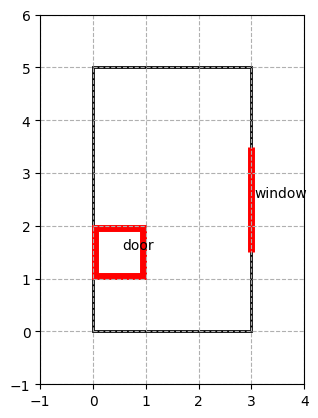

There is no bed in this room. Adding one now.


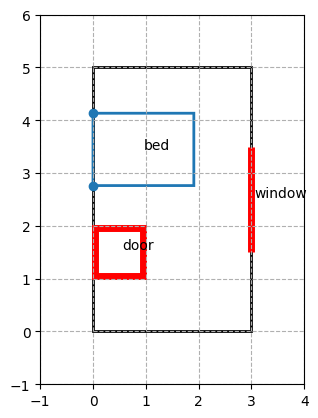

There are no nightstands in this room. Adding one now.


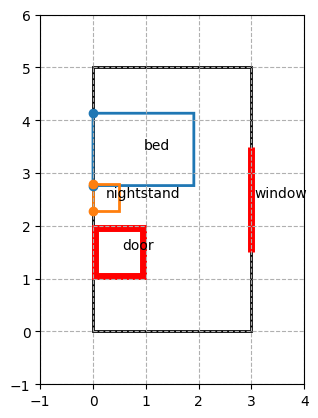

Adding a second nightstand.


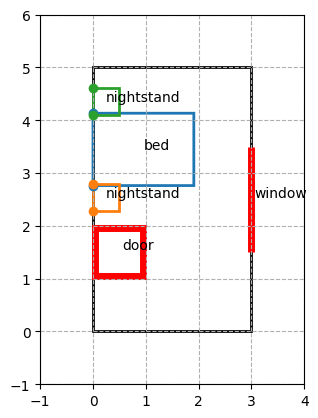

In [61]:
room = Room(3, 5)
room.fixed_objects = [Object('door', (0.5, 1.5), 0.91, 0.91), Object('window', (3, 2.5), 0, 2)]
room.draw()
add_bed(room, disp=True, orientation = 3*np.pi/2)
add_nightstand(room, disp=True, orientation = 3*np.pi/2)
add_nightstand(room, disp=True, orientation = 3*np.pi/2)

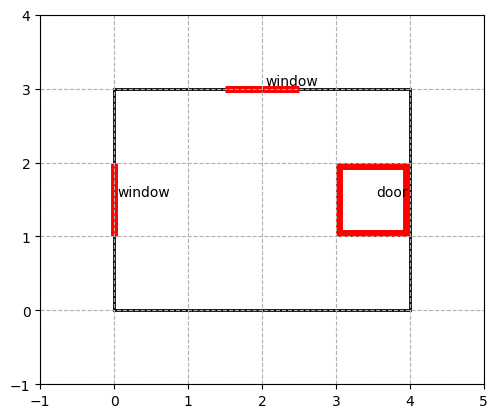

There is no bed in this room. Adding one now.


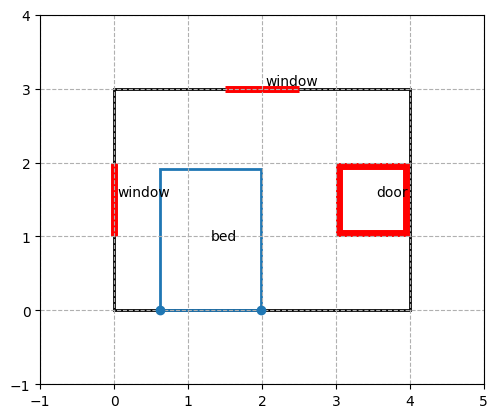

There are no nightstands in this room. Adding one now.


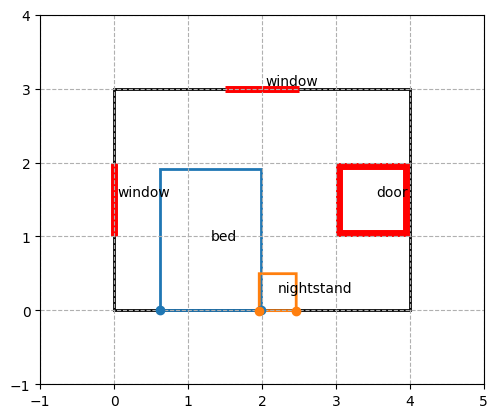

Adding a second nightstand.


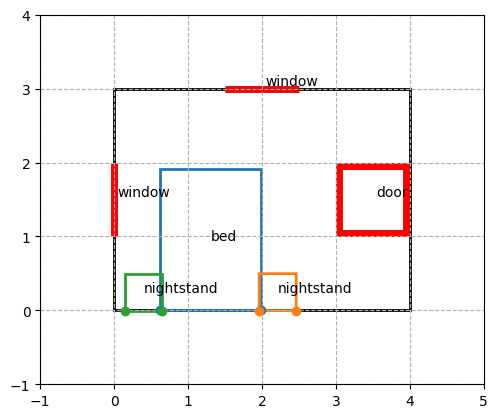

In [62]:
room = Room(4, 3)
room.fixed_objects = [Object('door', (3.5, 1.5), 0.91, 0.91), Object('window', (2, 3), 1, 0), Object('window', (0, 1.5), 0, 1)]
room.draw()
add_bed(room, disp=True, orientation = np.pi/2)
add_nightstand(room, disp=True, orientation = np.pi/4)
add_nightstand(room, disp=True, orientation = np.pi/4)

bed = room.find('bed')
ns = room.find_all('nightstand')

There is no bed in this room. Adding one now.
There are no nightstands in this room. Adding one now.
Adding a second nightstand.


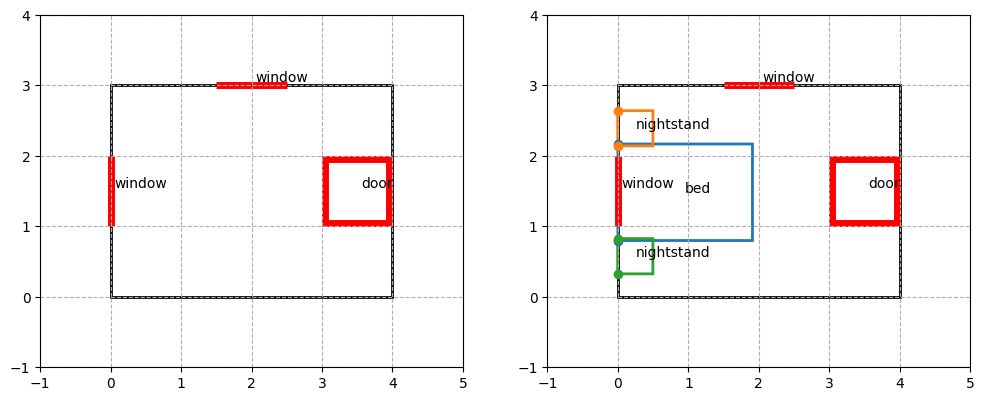

In [68]:
room = Room(4, 3)
room.fixed_objects = [Object('door', (3.5, 1.5), 0.91, 0.91), Object('window', (2, 3), 1, 0), Object('window', (0, 1.5), 0, 1)]
room.add([add_bed, add_nightstand, add_nightstand], orientation = 2*np.pi)